## Courte analyse sur DAYMET / ANUSPLIN et une station d'ECCC

Objectifs:

    - Travail sur les données ANUSPLIN et Daymet pour les années 2000 à 2010 (précipitation totale) autour des latitudes 50,66°N et 71,25°W 
    
 
On importe les librairies et on définit nos conditions initiales.

In [4]:
from netCDF4 import Dataset,num2date
import numpy as np
import pandas as pd
import datetime
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import Indices_Precipitation
from codes_station import get_closed_station_precip as get_Stat
import plot_grids
import matplotlib.pylab as plt
import warnings; warnings.filterwarnings(action='once')
import seaborn as sns
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")

rep_anus = 'J:/DONNEES_AMERIQUE_DU_NORD/ANUSPLIN_10km/Netcdf/all_domaine/Daily/'
rep_daymet = 'K:/PROJETS/PROJET_NAWRES/DAYMET_full_BOX/'
rep_station = 'K:/PROJETS/PROJET_NAWRES/DAYMET_full_BOX/'

yeari=1980
monthi=1
yearf = 2017
monthf = 12
lati = 50.66
loni = -71.25

Les fonctions suivantes nous permettrons d'extraire le point de grille le plus proche d'un fichier Netcdf et d'incrémenter sur les mois. 

In [3]:
def getclosest_ij(lats,lons,latpt,lonpt):
     # find squared distance of every point on grid
     dist_sq = (lats-latpt)**2 + (lons-lonpt)**2 
     # 1D index of minimum dist_sq element
     minindex_flattened = dist_sq.argmin()
     # Get 2D index for latvals and lonvals arrays from 1D index
     return np.unravel_index(minindex_flattened, lats.shape)

def add_month(now):
    try:
        then = (now + relativedelta(months=1)).replace(day=now.day)
    except ValueError:
        then = (now + relativedelta(months=2)).replace(day=1)
    return then


In [5]:
day_start=1
day_end = pd.date_range('{}-{}'.format(yearf, monthf), periods=1, freq='M').day.tolist()[0]
start=datetime.datetime(yeari,monthi,day_start)
end=datetime.datetime(yearf,monthf,day_end)
d0 = date(yeari, monthi, day_start)
d1 = date(yearf, monthf, day_end)
delta = d1 - d0
nb_days = delta.days+1

On travaille sur les points de grille d'ANUSPLIN. 

In [6]:
# Début de notre boucle temporelle sur anusplin
i=0
IND = []
incr=start
while incr <= end:
    filename= rep_anus + 'ANUSPLIN_10km_preacc_' + str(incr.year) + '_{:02d}'.format(incr.month) + '.nc'   
    f = Dataset(filename)
   # print(f.variables.keys()) # get all variable names
    var = f.variables['daily_precipitation_accumulation'] 
    #print(temp) 
    #temp.dimensions
    #temp.shape
    lat, lon = f.variables['latitude'], f.variables['longitude']
    #print(lat)
    #print(lon)
    #print(lat[:])
    # extract lat/lon values (in degrees) to numpy arrays
    latvals = lat[:]; lonvals = lon[:] 
    # a function to find the index of the point closest pt
    # (in squared distance) to give lat/lon value.    
    iy_min, ix_min = getclosest_ij(latvals, lonvals, lati, loni)
    #print(iy_min)
    #print(ix_min)
    IND.append(var[:,iy_min,ix_min])
    lat_a, lon_a = float(lat[iy_min,ix_min]), float(lon[iy_min,ix_min])
    incr=add_month(incr)
    
flattened_list = []    
flattened_list = [y for x in IND for y in x]
start=datetime.datetime(yeari,monthi,day_start)
TIME=[]
for i in range(0,nb_days,1): 
 #   TIME.append((start+timedelta(days=i)).strftime("%Y-%m-%d"))
    TIME.append((start+timedelta(days=i)))
dataFrame_ANUSPLIN = pd.DataFrame({'Date': TIME, 'Preacc': flattened_list}, columns = ['Date','Preacc']) 
dataFrame_ANUSPLIN = dataFrame_ANUSPLIN.set_index('Date')  

On fait de même sur les données de DAYMET. 

In [9]:
# Début de notre boucle temporelle sur daymet
i=0
IND = []
TIME=[]
for year in range(yeari,yearf+1):
    
    filename= rep_daymet + 'prcp_' + str(year) + '_DAYMET_subset.nc4' 
    f = Dataset(filename)
   # print(f.variables.keys()) # get all variable names
    var = f.variables['prcp'] 
    #var.dimensions
    #var.shape
    lat, lon = f.variables['lat'], f.variables['lon']
    #print(lat)
    #print(lon)
    #print(lat[:])
    # extract lat/lon values (in degrees) to numpy arrays
    latvals = lat[:]; lonvals = lon[:] 
    # a function to find the index of the point closest pt
    # (in squared distance) to give lat/lon value.    
    iy_min, ix_min = getclosest_ij(latvals, lonvals, lati, loni)
    lat_d, lon_d = float(lat[iy_min,ix_min]), float(lon[iy_min,ix_min])
    
    #print(iy_min)
    #print(ix_min)
    IND.append(var[:,iy_min,ix_min])
    nctime = f['time']
    test = pd.DataFrame({'DateTime': num2date(nctime[:], nctime.units, nctime.calendar)})
    test = test['DateTime'].mask(test['DateTime'].dt.year == 2011, 
                             test['DateTime'] + pd.offsets.DateOffset(year=year))        
    TIME.append(test)
    
    
flattened_list = []    
flattened_list = [y for x in IND for y in x]
flattened_time = []    
flattened_time = [y for x in TIME for y in x]

dataFrame_DAYMET = pd.DataFrame({'Date': flattened_time, 'Preacc': flattened_list}, columns = ['Date','Preacc']) 
dataFrame_DAYMET = dataFrame_DAYMET.set_index('Date')  

On va chercher la station d'ECCC la plus proche et extraire les données en utilisant la fonction get_closed_station_precip. 

In [10]:
# Données de la station la plus proche 

dataFrame_STATION, df_station = get_Stat(lati, loni, yeari, yearf)

Visualisation des sites:

####################
La station suivant sera extraire: 
                                     64
Prov                                 QC
nom de la station           BAGOTVILLE 
stnid              7060400             
année déb.                         1876
mois déb.                             1
année fin.                         2017
mois fin.                            12
lat (deg)                       48.3333
long (deg)                          -71
élév (m)                            159
stns jointes                        Yes
50.66
-71.25
50.625
-71.20833587646484
50.66544723510742
-71.25354766845703
48.333333333333336
-71.0


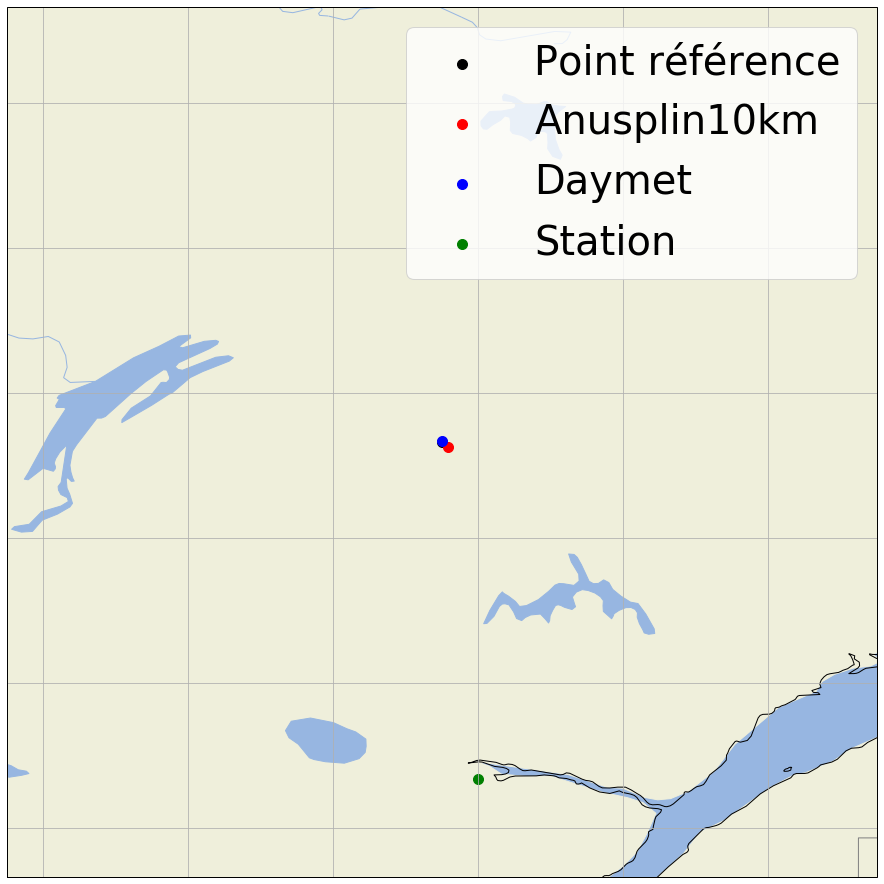

In [11]:
print("####################")
print("La station suivant sera extraire: ")
print(df_station)
lat_s = float(df_station.iloc[7].values)
lon_s = float(df_station.iloc[8].values)
dataFrame_STATION = dataFrame_STATION.loc[:,'variable'] 

grids_lat = []
grids_lon = []
grids_name = []
grids_lat.append(lati)
grids_lat.append(lat_a)
grids_lat.append(lat_d)
grids_lat.append(lat_s)

grids_lon.append(loni)
grids_lon.append(lon_a)
grids_lon.append(lon_d)
grids_lon.append(lon_s)

grids_name.append('Point référence')
grids_name.append('Anusplin10km')
grids_name.append('Daymet')
grids_name.append('Station')

plot_grids.plot_closed_points(grids_lat, grids_lon, grids_name, 'Precipitation')

On va calculer les indices de précipitation.

In [12]:
#################################### Calcul des indices mensuels     
resamp_preacc_A = dataFrame_ANUSPLIN.resample('M').agg([Indices_Precipitation.PrecTOT, Indices_Precipitation.MOY])   
resamp_preacc_A = resamp_preacc_A.loc[:,'Preacc'] 
resamp_preacc_A.head()

resamp_preacc_D = dataFrame_DAYMET.resample('M').agg([Indices_Precipitation.PrecTOT, Indices_Precipitation.MOY])   
resamp_preacc_D = resamp_preacc_D.loc[:,'Preacc'] 
resamp_preacc_D.head()

resamp_preacc_S = dataFrame_STATION.resample('M').agg([Indices_Precipitation.PrecTOT, Indices_Precipitation.MOY])   
resamp_preacc_S.head()
#################################### Calcul des indices annuels   
TIME=[]
for y in range(yeari,yearf+1,1):
    TIME.append(y)
    
annual1 = []
annual2 = []
df_annual_A = []
incr= date(yeari, 1, 1)
end = date(yearf, 12, 31)
while incr <= end:
     current_year = str(incr.year)
     annual1.append(Indices_Precipitation.PrecTOT(dataFrame_ANUSPLIN[current_year].values))  
     annual2.append(Indices_Precipitation.MOY(dataFrame_ANUSPLIN[current_year].values))    
     incr = incr + relativedelta(years=1)
               
df_annual_A = pd.DataFrame({'Date': TIME,'Annual PrecTOT': annual1, 'Annual Mean': annual2}, columns = ['Date','Annual PrecTOT', 'Annual Mean']) 
df_annual_A.head()

annual1 = []
annual2 = []
df_annual_D = []
incr= date(yeari, 1, 1)
end = date(yearf, 12, 31)
while incr <= end:
     current_year = str(incr.year)
     annual1.append(Indices_Precipitation.PrecTOT(dataFrame_DAYMET[current_year].values))  
     annual2.append(Indices_Precipitation.MOY(dataFrame_DAYMET[current_year].values))    
     incr = incr + relativedelta(years=1)
               
df_annual_D = pd.DataFrame({'Date': TIME,'Annual PrecTOT': annual1, 'Annual Mean': annual2}, columns = ['Date','Annual PrecTOT', 'Annual Mean']) 
df_annual_D.head()

annual1 = []
annual2 = []
df_annual_S = []
incr= date(yeari, 1, 1)
end = date(yearf, 12, 31)
while incr <= end:
     current_year = str(incr.year)
     annual1.append(Indices_Precipitation.PrecTOT(dataFrame_STATION[current_year].values))  
     annual2.append(Indices_Precipitation.MOY(dataFrame_STATION[current_year].values))    
     incr = incr + relativedelta(years=1)
               
df_annual_S = pd.DataFrame({'Date': TIME,'Annual PrecTOT': annual1, 'Annual Mean': annual2}, columns = ['Date','Annual PrecTOT', 'Annual Mean']) 
df_annual_S.head()




,Date,Annual PrecTOT,Annual Mean
0,1980,1022.15,2.792760
1,1981,1074.77,2.944575
2,1982,1099.17,3.011425
3,1983,1222.56,3.349479
4,1984,966.04,2.639454


On peut maintenant visualiser nos résultats.

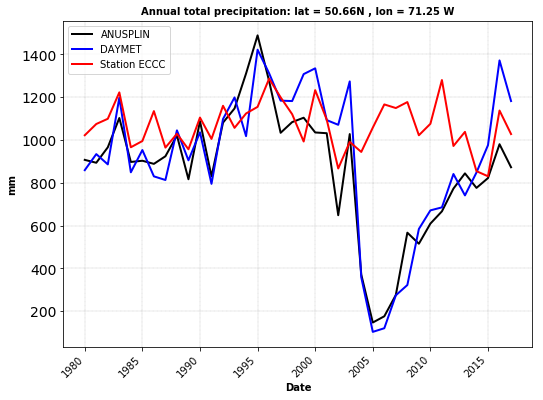

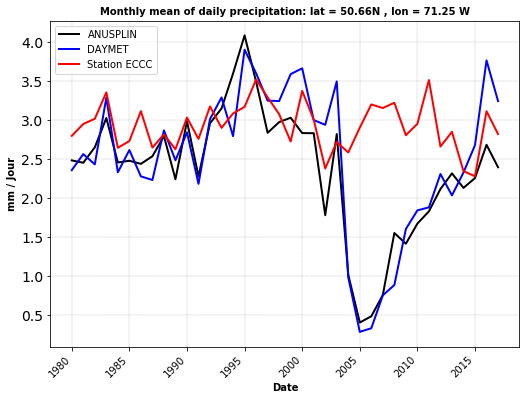

In [14]:
#################################### tracé des séries temporelles

color = ['black','blue', 'red']
fig = plt.figure(figsize=(10, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[6, 1]) 
gs.update( wspace=0.04)
ax1 = plt.subplot(gs[0])

plt.rcParams["figure.figsize"]=[16,9]       #  
plt.plot(df_annual_A['Date'].values, df_annual_A['Annual PrecTOT'][:],  label='ANUSPLIN', linewidth=2, c=color[0])
plt.plot(df_annual_D['Date'].values, df_annual_D['Annual PrecTOT'][:],  label='DAYMET', linewidth=2, c=color[1])
plt.plot(df_annual_S['Date'].values, df_annual_S['Annual PrecTOT'][:],  label='Station ECCC', linewidth=2, c=color[2])

ax1.grid(axis = "x", linestyle = "--", color='black', linewidth=0.25, alpha=0.5)
ax1.grid(axis = "y", linestyle = "--", color='black', linewidth=0.25, alpha=0.5)

plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")

plt.xlabel('Date', fontsize=10, color='black', weight='semibold')
plt.ylabel('mm', fontsize=10, color='black', weight='semibold')
plt.title('Annual total precipitation: lat = 50.66N , lon = 71.25 W', fontsize=10, color='black', weight='semibold')
 
ax1.set_facecolor('white')
plt.yticks( fontsize=14)
plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(0, 1, 1, 0),fontsize =10)
plt.savefig("Annual_precipitation_Time_serie_"+str(yeari)+"-"+str(yearf)+".png", dpi=300, bbox_inches='tight')   # bbox_inches= : option qui permet de propostionner le graphique lors de l'enregistrement
plt.show()

color = ['black','blue', 'red']
fig = plt.figure(figsize=(10, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[6, 1]) 
gs.update( wspace=0.04)
ax1 = plt.subplot(gs[0])

plt.rcParams["figure.figsize"]=[16,9]       #  
plt.plot(df_annual_A['Date'].values, df_annual_A['Annual Mean'][:],  label='ANUSPLIN', linewidth=2, c=color[0])
plt.plot(df_annual_D['Date'].values, df_annual_D['Annual Mean'][:],  label='DAYMET', linewidth=2, c=color[1])
plt.plot(df_annual_S['Date'].values, df_annual_S['Annual Mean'][:],  label='Station ECCC', linewidth=2, c=color[2])

ax1.grid(axis = "x", linestyle = "--", color='black', linewidth=0.25, alpha=0.5)
ax1.grid(axis = "y", linestyle = "--", color='black', linewidth=0.25, alpha=0.5)

plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")

plt.xlabel('Date', fontsize=10, color='black', weight='semibold')
plt.ylabel('mm / Jour', fontsize=10, color='black', weight='semibold')
plt.title('Monthly mean of daily precipitation: lat = 50.66N , lon = 71.25 W', fontsize=10, color='black', weight='semibold')
 
ax1.set_facecolor('white')
plt.yticks( fontsize=14)
plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(0, 1, 1, 0),fontsize =10)
plt.savefig("Monthly_mean_precipitation_ANUSPLIN_"+str(yeari)+"-"+str(yearf)+".png", dpi=300, bbox_inches='tight')   # bbox_inches= : option qui permet de propostionner le graphique lors de l'enregistrement
plt.show()

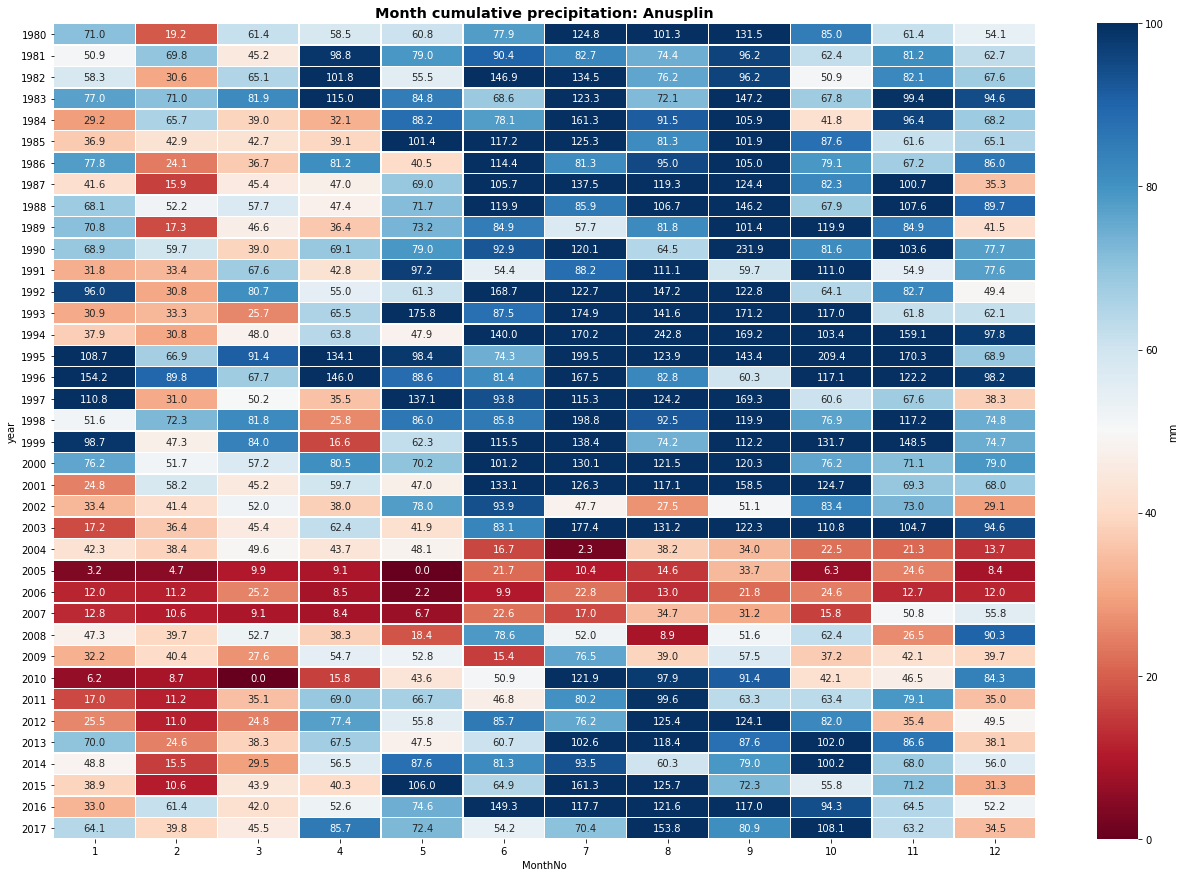

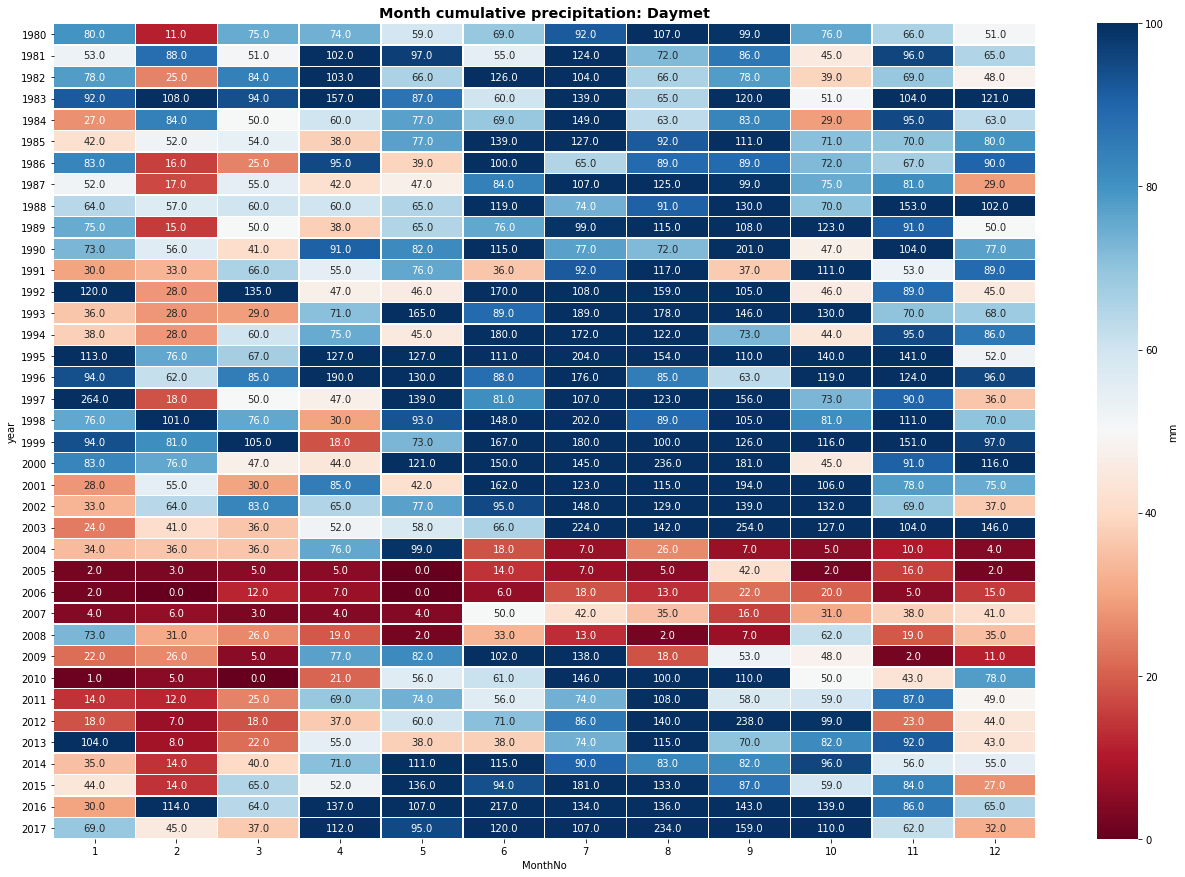

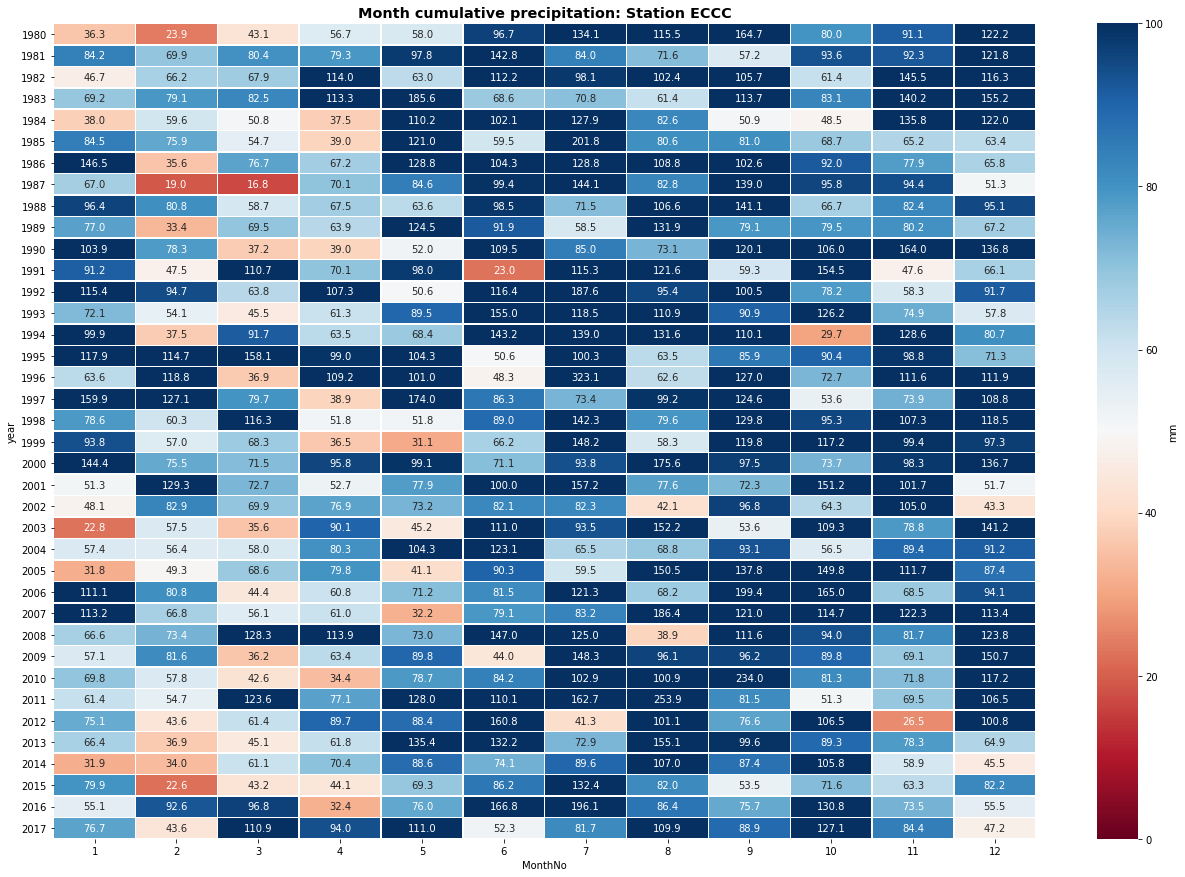

In [15]:
### heat map

resamp_preacc_A['year']  = resamp_preacc_A.index.year
resamp_preacc_A['MonthNo'] = resamp_preacc_A.index.month
resamp_preacc_A = resamp_preacc_A.pivot_table(values='PrecTOT',index='year',columns=['MonthNo'])
ax = plt.axes()
sns.heatmap(resamp_preacc_A, cmap='RdBu', linewidths=0.5, annot=True , ax = ax,vmin=0, vmax=100,center=50, fmt='.1f',yticklabels=True, cbar_kws={'label': 'mm'})
ax.set_title('Month cumulative precipitation: Anusplin', weight='bold', fontsize="x-large")
figure = ax.get_figure()    
figure.set_size_inches(22, 15) 
plt.savefig("Month_cumulative_precipitation_Anusplin.png", dpi=300, bbox_inches='tight')   # bbox_inches= : option qui permet de propostionner le graphique lors de l'enregistrement
plt.show()

resamp_preacc_D['year']  = resamp_preacc_D.index.year
resamp_preacc_D['MonthNo'] = resamp_preacc_D.index.month
resamp_preacc_D = resamp_preacc_D.pivot_table(values='PrecTOT',index='year',columns=['MonthNo'])
ax = plt.axes()
sns.heatmap(resamp_preacc_D, cmap='RdBu', linewidths=0.5, annot=True , ax = ax,vmin=0, vmax=100,center=50, fmt='.1f',yticklabels=True, cbar_kws={'label': 'mm'})
ax.set_title('Month cumulative precipitation: Daymet', weight='bold', fontsize="x-large")
figure = ax.get_figure()    
figure.set_size_inches(22, 15) 
plt.savefig("Month_cumulative_precipitation_Daymet.png", dpi=300, bbox_inches='tight')   # bbox_inches= : option qui permet de propostionner le graphique lors de l'enregistrement
plt.show()


resamp_preacc_S['year']  = resamp_preacc_S.index.year
resamp_preacc_S['MonthNo'] = resamp_preacc_S.index.month
resamp_preacc_S['PrecTOT']
resamp_preacc_S = resamp_preacc_S.pivot_table(values='PrecTOT',index='year',columns=['MonthNo'])
ax = plt.axes()
sns.heatmap(resamp_preacc_S, cmap='RdBu', linewidths=0.5, annot=True , ax = ax,vmin=0, vmax=100,center=50, fmt='.1f',yticklabels=True, cbar_kws={'label': 'mm'})
ax.set_title('Month cumulative precipitation: Station ECCC', weight='bold', fontsize="x-large")
figure = ax.get_figure()    
figure.set_size_inches(22, 15) 
plt.savefig("Month_cumulative_precipitation_Station.png", dpi=300, bbox_inches='tight')   # bbox_inches= : option qui permet de propostionner le graphique lors de l'enregistrement
plt.show()